In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torchinfo import summary
import random
import os
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torch import optim
from typing import Dict, List, Tuple

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device : ", device)

if device == "cpu":
    num_workers=os.cpu_count()
    print("num_workers :", num_workers)

device :  cpu
num_workers : 8


c:\anaconda\envs\VIT_Venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
random_seed= 42

random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [7]:
# pretrained ViY-Base model
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# model
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

In [8]:
# model details
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), 
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings= ["var_names"]
    )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

## dataset

In [9]:
train_data_dir = "flowers-data/train"
test_data_dir = "flowers-data/test"
val_data_dir = "flowers-data/valid"

In [10]:
# get pre-trained model transforms

pre_trained_model_transforms = pretrained_vit_weights.transforms()
pre_trained_model_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [23]:
transform_ = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

In [11]:
def create_dataloaders(train_dir: str, test_dir: str, valid_dir:str ,transform: transforms.Compose, batch_size: int, num_workers: int):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    valid_data = datasets.ImageFolder(valid_dir, transform=transform)
    
    classes = train_data.classes
    
    train_dataloader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    
    test_dataloader = DataLoader(
        test_data , shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True
    )
    
    valid_dataloader = DataLoader(
        valid_data , shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True
    )
    
    return train_dataloader, test_dataloader, valid_dataloader,classes
    
    

In [12]:
train_dataloader, test_dataloader, valid_dataloader, classes = create_dataloaders(
                                                    train_dir=train_data_dir,
                                                    test_dir=test_data_dir,
                                                    valid_dir=val_data_dir,
                                                    transform=pre_trained_model_transforms,
                                                    batch_size=32,
                                                    num_workers=num_workers
                                                )

In [13]:
classes

['balloon flower',
 'camellia',
 'clematis',
 'geranium',
 'japanese anemone',
 'magnolia',
 'purple coneflower',
 'spring crocus',
 'stemless gentian',
 'trumpet creeper']

In [14]:
# freeze the model parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(classes)).to(device)

In [15]:
# modified model details
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), 
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings= ["var_names"]
    )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

# training

In [16]:
import torch.optim.optimizer


def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device
        ):
    
    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch, (x, y) in enumerate(dataloader):
        x,y = x.to(device), y.to(device)
        
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_classes = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        
        train_acc += sum(1 for i, j in zip(y_pred_classes, y) if i==j) / len(y_pred_classes)
    
    avg_loss = train_loss / len(dataloader)
    avg_acc = train_acc / len(dataloader)
    
    return avg_loss, avg_acc
        
def test_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device
        ):
    
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
            x,y = x.to(device), y.to(device)
            
            y_pred = model(x)
            
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            y_pred_classes = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += sum(1 for i, j in zip(y_pred_classes, y) if i==j) / len(y_pred_classes)
        
    avg_loss = test_loss / len(dataloader)
    avg_acc = test_acc / len(dataloader)
    
    return avg_loss, avg_acc
    
    

def train(
        model : torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        epochs: int,
        device
    ):
    result = {
        "train_loss" : [],
        "train_acc" : [],
        "test_loss" : [],
        "test_acc" : []
    }
    
    for epoch in tqdm(range(epochs), desc="training"):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc  = test_step(model, test_dataloader, loss_fn, device)
        
        
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        result["train_loss"].append(train_loss)
        result["train_acc"].append(train_acc)
        result["test_loss"].append(test_loss)
        result["test_acc"].append(test_acc)
        
    return result
    
    

## start training

In [ ]:
optimizer = optim.Adam(params=pretrained_vit.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
epochs = 40

training_results = train(
                model=pretrained_vit, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device
            )

In [ ]:
training_results

In [ ]:
"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import os
import zipfile
from pathlib import Path
import requests
import os


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)


### predictions

In [ ]:
image_path  = "flowers-data/valid/balloon flower/image_06151_jpg.rf.d000204c9314ae6defd2dac6b975060e.jpg"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6304002].


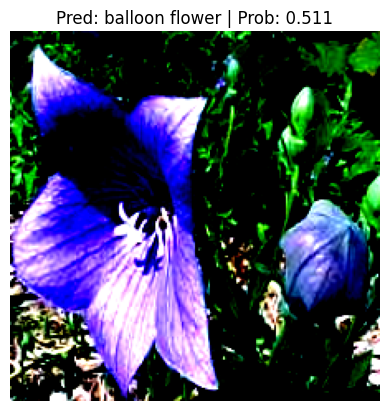

In [ ]:
pred_and_plot_image(
    model=pretrained_vit, 
    image_path = image_path,
    class_names = classes,
    transform=pre_trained_model_transforms
)

In [ ]:
image_path = "flowers-data/valid/magnolia/image_05460_jpg.rf.6b6264120ba6fb96c7e4e041432cf204.jpg"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8169497..2.64].


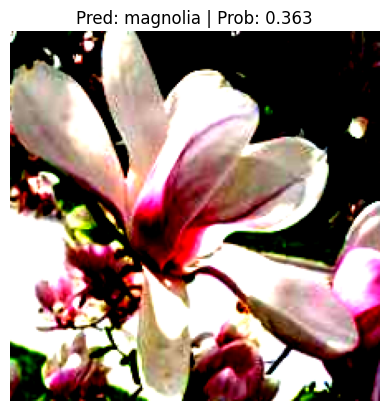

In [ ]:
pred_and_plot_image(
    model=pretrained_vit, 
    image_path = image_path,
    class_names = classes,
    transform=pre_trained_model_transforms
)